In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/brain_aging/results/00_Microglia_RNA/'
dataDirectory = '/data/mm10/Brain_MPSIIIA/RNA/Microglia/WT/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# Read in data
We will match based on refseq to make sure we are pulling the same promoter as in the tpm 

### Read in TPM from homer file with refseq ID

In [69]:
tpm = pd.read_csv('./expression/HOMER.rawTPM.txt',
                      sep='\t', index_col=0)

tpm_mat = tpm.loc[:, tpm.columns.str.contains('4month|24months|26months')]

Average tag counts

In [72]:
groups = ['rna_4month', 'rna_20monthPlus']
columns = [[0,1,2],
           [3,4,5]]

avg_tpm = {}

for group, col in zip(groups, columns):
    avg_tpm[group] = tpm_mat.iloc[:, col].mean(1)
    
avg_tpm_df = pd.DataFrame(avg_tpm)

## Read in H3K27Ac promoter tags (normalized)

In [43]:
from homer_preprocessing import read_annotated_peaks

In [74]:
h3k27ac_tss, mat = read_annotated_peaks('./annotatedTSS_H3K27Ac_4mo_25mo.txt')
# this is unfiltered and contains different p

# set gene name as index
# h3k27ac_tss = h3k27ac_tss.set_index('Gene Name')
# filter to matrix
h3k27ac_tss_mat = h3k27ac_tss.loc[:, h3k27ac_tss.columns.str.contains('Brain_MPSIIIA')]

Pull average tags by group

In [79]:
groups = ['h3k27ac_4month', 'h3k27ac_20monthPlus']
columns = [[0,1,2,3],
           [4,5,6]]

avg_h3k27ac = {}

for group, col in zip(groups, columns):
    avg_h3k27ac[group] = h3k27ac_tss_mat.iloc[:, col].mean(1)
    
avg_h3k27ac_df = pd.DataFrame(avg_h3k27ac)

## Merge into combined data frame for plotting

In [80]:
tpm_h3k27ac_df = pd.merge(avg_tpm_df,
                          avg_h3k27ac_df,
                          left_index=True,
                          right_index=True,
                          how='left')

In [91]:
tpm_h3k27ac_df.columns

Index(['rna_4month', 'rna_20monthPlus', 'h3k27ac_4month',
       'h3k27ac_20monthPlus'],
      dtype='object')

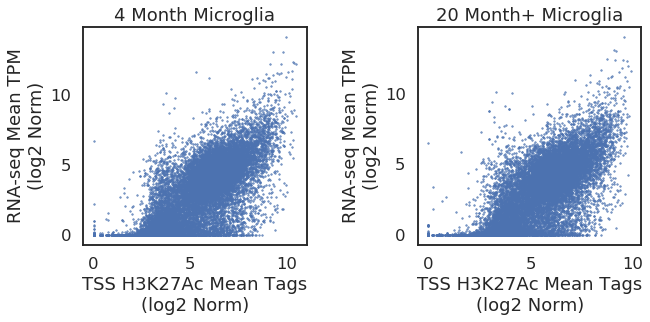

In [105]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.5)

axs[0].scatter(np.log2(tpm_h3k27ac_df.h3k27ac_4month+1),
           np.log2(tpm_h3k27ac_df.rna_4month+1),
           s=0.5)

axs[0].set_xlabel('TSS H3K27Ac Mean Tags\n(log2 Norm)');
axs[0].set_ylabel('RNA-seq Mean TPM\n(log2 Norm)');
axs[0].set_title('4 Month Microglia');

axs[1].scatter(np.log2(tpm_h3k27ac_df.h3k27ac_20monthPlus+1),
           np.log2(tpm_h3k27ac_df.rna_20monthPlus+1),
           s=0.5)

axs[1].set_xlabel('TSS H3K27Ac Mean Tags\n(log2 Norm)');
axs[1].set_ylabel('RNA-seq Mean TPM\n(log2 Norm)');
axs[1].set_title('20 Month+ Microglia');

In [106]:
tpm_h3k27ac_df.corr()

,rna_4month,rna_20monthPlus,h3k27ac_4month,h3k27ac_20monthPlus
rna_4month,1.000000,0.972241,0.345406,0.319930
rna_20monthPlus,0.972241,1.000000,0.342319,0.321848
h3k27ac_4month,0.345406,0.342319,1.000000,0.975390
h3k27ac_20monthPlus,0.319930,0.321848,0.975390,1.000000


In [108]:
tpm_h3k27ac_df.corr(method='spearman')

,rna_4month,rna_20monthPlus,h3k27ac_4month,h3k27ac_20monthPlus
rna_4month,1.000000,0.951615,0.777985,0.770926
rna_20monthPlus,0.951615,1.000000,0.783080,0.780367
h3k27ac_4month,0.777985,0.783080,1.000000,0.898852
h3k27ac_20monthPlus,0.770926,0.780367,0.898852,1.000000


We could implement Inge's test and compare the spearman correlation between all 4 month old samples and all ChIP-seq samples and then compare the distribution of the correlations?